In this notebook, we use the BirdNET model to classify Puerto Rican bird and frog species. Because they are not in the original BirdNET training data, we do this by cutting out the last layer and replacing it with a logistic regression trained on the species from Puerto Rico.

In [4]:
import numpy as np
import os
import librosa
import keras
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

2023-06-02 13:33:59.381795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [5]:
# load the BirdNET model; embedding_model will the model minus the last layer, 
# providing an embedding into a 1024-dimensional vector space
# the warnings come from the way the model was saved and can be ignored
model_path = 'BirdNET-Analyzer/checkpoints/V2.3/BirdNET_GLOBAL_3K_V2.3_Model'
model = keras.models.load_model(model_path, compile=False).model
embedding_model = keras.Model(inputs = model.input, outputs = model.get_layer('CONCAT_DO').output)

In [6]:
# read the Puerto Rican bird data into 3 second clips. We use the files from the folder 'clips_with_context',
# and randomly select a 3 second subclip of them. We do this in 3 different ways for augmentation
rng = np.random.default_rng(seed = 42)

samples = []
types = []
path = 'clips_with_context'

for species in os.listdir(path):
    for clip in os.listdir('%s/%s' % (path, species)):
        input_filename = '%s/%s/%s' % (path, species, clip)
        
        clear_output(wait = True)
        print('processing file: %s' % input_filename)
        
        sig, _ = librosa.load(input_filename, sr = 48000, res_type = 'kaiser_fast')

        for i in range(3):
            target_len = 3*48000
            start = rng.integers(0, len(sig) - target_len)
            end = start + target_len
            
            samples.append(sig[start:end])
            types.append(species)
            
typesnp = np.array(types)
unique_types = np.unique(typesnp)

processing file: clips_with_context/s13-1/song0633.wav


In [7]:
# run the BirdNET model on the data to get embeddings
embeddings = embedding_model.predict(np.array(samples))
embeddings.shape

114/114 [==============================] - 133s 1s/step


(3648, 1024)

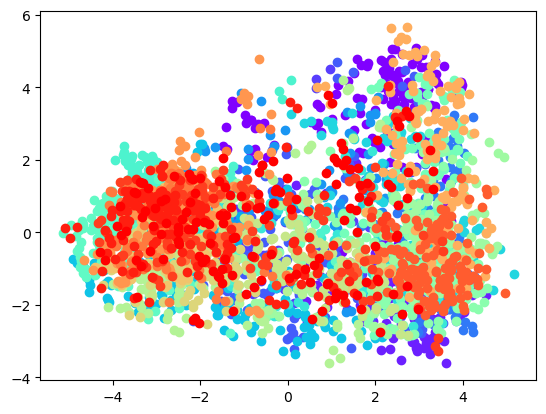

In [70]:
# as a first visualization, project the data to two dimension via PCA
pca = PCA(2)
pca.fit(embeddings)
transformed = pca.transform(embeddings)

color = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))

for t, c in zip(unique_types, color):
    plt.scatter(transformed[typesnp == t,0], transformed[typesnp == t,1], color = c)

In [39]:
# do a train-test-split with 15% test data. We don't use the function from sklearn here because we want
# to make sure that differently shifted versions of the same recording (see augmentation above) don't end up
# in both the train and test data, and inflate the accuracy score
rng = np.random.default_rng(2023)

n_test = int(1216*0.15)
indices = rng.permutation(1216)
test_indices = indices[:n_test]
train_indices = indices[n_test:]
X_test = embeddings.reshape(-1,3,1024)[test_indices][:,0,:]
X_train = embeddings.reshape(-1,3,1024)[train_indices].reshape(-1,1024)
y_test = typesnp.reshape(-1,3)[test_indices][:,0]
y_train = typesnp.reshape(-1,3)[train_indices].reshape(-1)

In [ ]:
# logistic regression on BirdNET embeddings with augmentation, trying different levels of regularization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_accuracies = []
test_accuracies = []

for alpha in np.linspace(0.0,10.0,50):
    clear_output(wait = True)
    print('C = %.6f' % math.exp(-alpha))

    reg = LogisticRegression(max_iter=1000, penalty = 'l2', C=math.exp(-alpha)).fit(X_train_scaled, y_train)
    y_train_pred = reg.predict(X_train_scaled)
    y_test_pred = reg.predict(X_test_scaled)
    train_accuracies.append(np.count_nonzero(y_train == y_train_pred) / len(y_train))
    test_accuracies.append(np.count_nonzero(y_test == y_test_pred) / len(y_test))

C_values = np.exp(-np.linspace(0.0,10.0,50))

In [1]:
plt.xscale('log')
plt.plot(C_values,train_accuracies)
plt.plot(C_values,test_accuracies)
plt.ylim((0.6,1.0))
plt.grid()
plt.show()

NameError: name 'plt' is not defined

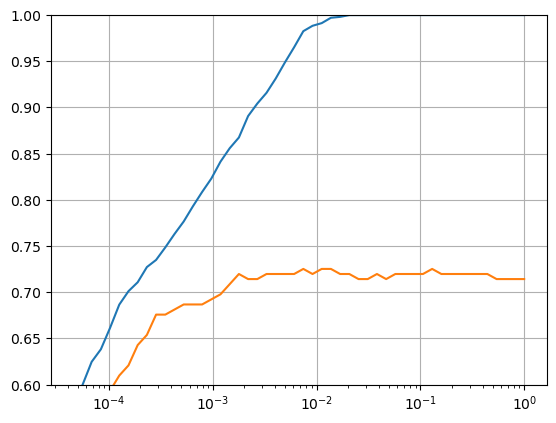

In [54]:
# logistic regression on BirdNET embeddings, without augmentation, again with different levels of regularization
X_train_simple = X_train.reshape(-1,3,1024)[:,0,:]
y_train_simple = y_train.reshape(-1,3)[:,0]

scaler = StandardScaler().fit(X_train_simple)
X_train_scaled = scaler.transform(X_train_simple)
X_test_scaled = scaler.transform(X_test)

train_accuracies = []
test_accuracies = []

for alpha in np.linspace(0.0,10.0,50):
    clear_output(wait = True)
    print('C = %.6f' % math.exp(-alpha))

    reg = LogisticRegression(max_iter=1000, penalty = 'l2', C=math.exp(-alpha)).fit(X_train_scaled, y_train_simple)
    y_train_pred = reg.predict(X_train_scaled)
    y_test_pred = reg.predict(X_test_scaled)
    train_accuracies.append(np.count_nonzero(y_train_simple == y_train_pred) / len(y_train_simple))
    test_accuracies.append(np.count_nonzero(y_test == y_test_pred) / len(y_test))

C_values = np.exp(-np.linspace(0.0,10.0,50))

plt.xscale('log')
plt.plot(C_values,train_accuracies)
plt.plot(C_values,test_accuracies)
plt.ylim((0.6,1.0))
plt.grid()
plt.show()

In [57]:
# same as the first experiment (logistic regression on the data with augmentation), but this time first use a PCA
# to 128 dimensions to reduce overfitting
train_accuracies = []
test_accuracies = []

for alpha in np.linspace(0.0,10.0,100):
    clear_output(wait = True)
    print('C = %.6f' % math.exp(-alpha))

    log_reg_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(128)),
        ('log_reg', LogisticRegression(max_iter=1000, penalty='l2', C=math.exp(-alpha)))])

    
    log_reg_model.fit(X_train, y_train)
    y_train_pred = log_reg_model.predict(X_train)
    y_test_pred = log_reg_model.predict(X_test)
    train_accuracies.append(np.count_nonzero(y_train == y_train_pred) / len(y_train))
    test_accuracies.append(np.count_nonzero(y_test == y_test_pred) / len(y_test))

C = 0.000045


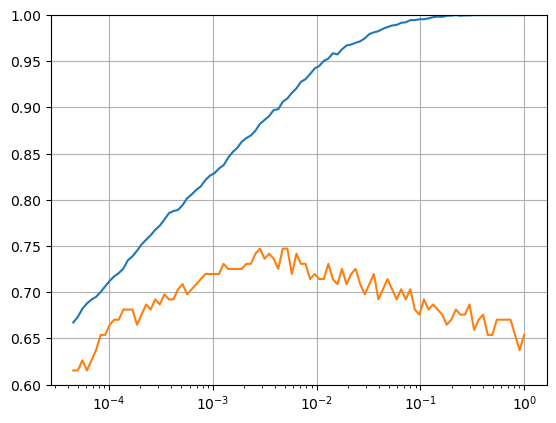

In [59]:
C_values = np.exp(-np.linspace(0.0,10.0,100))

plt.xscale('log')
plt.plot(C_values,train_accuracies)

plt.plot(C_values,test_accuracies)
plt.ylim((0.6,1.0))
plt.grid()
plt.show()

We conclude that the best results are obtained from a logistic regression trained with the augmented data, and using a regularization penalty of about $C = 0.02$.

In [61]:
log_reg_model = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, penalty='l2', C=0.02))])

log_reg_model.fit(X_train, y_train)
y_train_pred = log_reg_model.predict(X_train)
y_test_pred = log_reg_model.predict(X_test)

In [68]:
print("%d of %d test samples predicted correctly, %.1f%% accuracy" %
(np.sum(y_test_pred == y_test), len(y_test), np.sum(y_test_pred == y_test) / len(y_test) * 100))
print("%d of %d training samples predicted correctly, %.1f%% accuracy" %
(np.sum(y_train_pred == y_train), len(y_train), np.sum(y_train_pred == y_train) / len(y_train) * 100))

139 of 182 test samples predicted correctly, 76.4% accuracy
3100 of 3102 training samples predicted correctly, 99.9% accuracy
